Objective 1c: 

* Amend the functionality of the Blackjack multiple hands and betting module so that it can smoothly and practically simulate hands over potentially millions of iterations.

Why is this casino-based realism important, it doesn't matter from a software engineering perspective/Rich Sutton doesn't do it? This is related to what we would like to investigate. We would like to investigate:


* Investigate/reproduce the calculation of the house edge when a basic strategy is played.
* Investigate the effect of varying player strategies, including various forms of card-counting.
* Investigate the effect of varying betting strategies by the player.
* Investigate any counterfactuals you might be interested in e.g. how would a savant compare against a card-counter?


Possible extension questions:

* Can machine learning or principles in computer science assist in the problem?
* If so, how and in what way could those disciplines' relative strengths be best leveraged to assist?
* If card-counting really is an effective strategy, as confirmed, or via correct implementation of its principles (non-trivial once you factor in betting strategies and money management), would an algorithm be able to deduce this strategy?
* There are multiple threads from which to think about the problem of Blackjack: simulation based analysis (pursuing and most interested), statistical/probabilistic/combinatorial analysis, machine learning.


For presentation purposes, need to emphasise:


* Admit possibility that code could be written more efficiently, how(?)
* That each module was written from the perspective of playing at a casino, so the logical flow of the modules should be intuitive, and also so that later more advanced, casino specific functionality can be introduced.
* A game tree to help the reader understand the action sequence of the game - can be a computer science or game theory one.
* Appropriately cover caveats. e.g. pseudo-random number generation



In [3]:
import random
import timeit
from collections import Counter
import pandas as pd
from matplotlib import pyplot

In [4]:
# Stack function definitions together 

def getcards(decks=1):
    """Brings out a number of sealed decks of cards in their original order to the virutal gaming table.

    Creates a dictionary tracking the name of each card, its quantity, and its value
    
    Keyword argument:
        decks {int} -- the number of 52-card decks that the casino is using (default 1)
    
    Returns:
        dictionary{keys: values} -- dictionary object where keys are the card name (e.g. 'K' for King )
                                    and where the values are a list object containing the card's quantity and its value.
                                    
    The value for the ace contains three elements, as aces can further take on the value of 1 or 11, depending on 
    the context of the hand. No distinction is made between card suits, i.e. spades, hearts, clubs, diamonds.
    """
    
    deck = {}
    total_cards = decks * 52
    card_quantity = int(total_cards / 13)
    
    deck['A'] = [card_quantity, 1, 11]

    for card in range(2, 11):
        deck[str(card)] = [card_quantity, card]
    
    for card in "JQK":
        deck[str(card)] = [card_quantity, 10]
        
    return deck, total_cards

def shuffler(deck, total_cards):
    
    """Shuffles the decks of cards, and places them inside the virtual gaming table card-shoe."""
    
    shuffled_shoe = []
    
    while len(shuffled_shoe) < total_cards:
        draw = random.choice(list(deck))
        if deck[draw][0] == 0:
            pass
        else:
            deck[draw][0] -= 1
            shuffled_shoe.append(draw)
            
    return shuffled_shoe

def openinghand():
    
    """Deals two cards to the player, and one to the dealer from the shuffled shoe. Outputs a message if there is Blackjack
    
    Cards are taken sequentially from the shuffled card shoe, beginning with the last element of the shuffled shoe list object
    and working in reverse order."""
    
    player = []
    dealer = []

    player.append(shuffled_shoe.pop())
    player.append(shuffled_shoe.pop())
    
    dealer.append(shuffled_shoe.pop())
    
    if ('A' in player) and (('10' in player) or ('J' in player) or ('Q' in player) or ('K' in player)):
        print("Blackjack, house pays out at 3:2")
    else:
        print("No Blackjack this time")
        
    return player, dealer

def playerturn(player):
    
    """Evaluates the player's score, and keeps drawing cards until the player has a score of more than 18"""
    
    cardvalues = []
    for card in player:
        cardvalues.append(deck[card][1])

    while sum(cardvalues) < 18:
        drawcard = shuffled_shoe.pop()
        player.append(drawcard)
        cardvalues.append(deck[drawcard][1])
        print("Decided to hit, as I'm a risk lover and under 18")
        
    if sum(cardvalues) > 21:
        print("...I've gone bust. Why is my lucky charm that I got from the Amazonian shaman not working?")
    else:
        print("Decided to stick")
        
    print("Player Score:" + str(sum(cardvalues)))
    print(player)
        
    return player, sum(cardvalues)

def dealerturn(dealer):
    
    """Evaluates the dealer's score, and keeps drawing cards until dealer has a score of 17 or more."""
    
    cardvalues = []
    for card in dealer:
        cardvalues.append(deck[card][1])
        
    while sum(cardvalues) <= 16:
        drawcard = shuffled_shoe.pop()
        dealer.append(drawcard)
        cardvalues.append(deck[drawcard][1])
        print("Dealer draws a card as under or equal to 16")
    
    if sum(cardvalues) > 21:
        print("Dealer goes bust")
    else:
        print("Dealer sticks on 17 or over")
    
    print("Dealer Score:" + str(sum(cardvalues)))
    print(dealer)
    
    return dealer, sum(cardvalues)

def handoutcome(playerscore, dealerscore):
    
    """Compares player's and dealer's scores and encodes the outcome.
    
    Can be extended if analysis required tracking the evolution of this variable."""

    if playerscore > 21:
        if dealerscore > 21:
            hand_outcome = 0
            print("Player busts. Dealer also busts. But the 'edge' means that player loses the hand.")
        else:
            hand_outcome = 0
            print("Player busts. Dealer wins the hand.")
    else:
        if dealerscore > 21:
            hand_outcome = 1
            print("Dealer busts. Player wins the hand")
        else:
            if dealerscore > playerscore:
                hand_outcome = 0
                print("Dealer has higher score. Dealer wins the hand")
            elif dealerscore < playerscore:
                hand_outcome = 1
                print("Player has higher score. Player wins the hand")
            else:
                hand_outcome = 2
                print("Both dealer and player have the same score, the outcome of the hand is a draw")
    
    return hand_outcome

def payout_loss(hand_outcome):
    
    """Uses the outcome to calculate payoffs/losses, and updates player's capital stock accordingly."""
    
    global capital_stock
    
    if hand_outcome == 1:
        new_capital = capital_stock[-1] + bet_per_round
        capital_stock.append(new_capital)
        print("House pays out " + str(bet_per_round) + " pounds")
    elif hand_outcome == 0:
        new_capital = capital_stock[-1] - bet_per_round
        capital_stock.append(new_capital)
        print("Player loses " + str(bet_per_round) + " pounds")
    else:
        new_capital = capital_stock[-1]
        capital_stock.append(new_capital)
        print("Draw, no change to player's initial capital")
        
    print("Player now has" + " " + str(capital_stock[-1]) + " " + "pounds remaining.")
        
    return capital_stock

def replenish_shoe(threshold):
    
    """Checks whether or not  we are near the end of a shoe. If so, discards the remaining cards in the current shoe,
    collects them together with remaining cards that were discarded in previous hands, reshuffles all of them togther,
    and finally replenishes the shoe."""
    
    global deck
    global total_cards
    global shuffled_shoe
    
    fraction_cards_remaining = len(shuffled_shoe) / total_cards
    
    if fraction_cards_remaining < threshold:
        shuffled_shoe.clear
        deck, total_cards = getcards(decks=1)
        shuffled_shoe = shuffler(deck, total_cards)
        print("As we are reaching near the end of the shoe, we will reshuffle")
    else:
        print("No need for reshuffling yet, as card threshold not reached")

    return shuffled_shoe

In [5]:
# Write a function that appropriately calls each function module that can iterate over 100 rounds. Piece by piece.
# Roughshod simulator completed.

In [23]:
random.seed(1)

In [59]:
initial_capital = 0
capital_stock = [initial_capital]
bet_per_round = 1

In [60]:
deck, total_cards = getcards(decks=4)
shuffled_shoe = shuffler(deck, total_cards)

In [61]:
def blackjack_simulator(iterations):
    
    for iteration in range(iterations):
        
        print("---ROUND {}---".format(iteration))
        player, dealer = openinghand()
        player, playerscore = playerturn(player)
        dealer, dealerscore = dealerturn(dealer)
        hand_outcome = handoutcome(playerscore, dealerscore)
        capital_stock = payout_loss(hand_outcome)
        shuffled_shoe = replenish_shoe(0.4)
    
    return capital_stock

In [62]:
blackjack_simulator(1000)

---ROUND 0---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
...I've gone bust. Why is my lucky charm that I got from the Amazonian shaman not working?
Player Score:26
['8', '8', '10']
Dealer draws a card as under or equal to 16
Dealer sticks on 17 or over
Dealer Score:17
['10', '7']
Player busts. Dealer wins the hand.
Player loses 1 pounds
Player now has -1 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 1---
No Blackjack this time
Decided to stick
Player Score:20
['10', '10']
Dealer draws a card as under or equal to 16
Dealer sticks on 17 or over
Dealer Score:17
['7', 'J']
Player has higher score. Player wins the hand
House pays out 1 pounds
Player now has 0 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 2---
No Blackjack this time
Decided to stick
Player Score:18
['Q', '8']
Dealer draws a card as under or equal to 16
Dealer sticks on 17 or over
Dealer Score:20
['J', 'J']
Dealer has 

Player now has -21 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 172---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
Decided to stick
Player Score:21
['5', '6', 'K']
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer goes bust
Dealer Score:24
['7', '3', '4', 'J']
Dealer busts. Player wins the hand
House pays out 1 pounds
Player now has -20 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 173---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
Decided to stick
Player Score:21
['Q', '2', '9']
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer goes bust
Dealer Score:25
['5', '10', 'K']
Dealer busts. Player wins the hand
House pays out 1 pounds
Player now has -19 pounds remaining.
As we are reaching near the end of the shoe, we will re

Dealer Score:19
['6', '5', 'A', '7']
Player has higher score. Player wins the hand
House pays out 1 pounds
Player now has -34 pounds remaining.
As we are reaching near the end of the shoe, we will reshuffle
---ROUND 334---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
Decided to stick
Player Score:19
['7', '10', '2']
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer sticks on 17 or over
Dealer Score:18
['A', '2', '7', '2', '6']
Player has higher score. Player wins the hand
House pays out 1 pounds
Player now has -33 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 335---
No Blackjack this time
Decided to stick
Player Score:20
['J', 'K']
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer sticks on 17 or over
Dealer Score:17
['7', '9', 'A']
Player has h

Player loses 1 pounds
Player now has -55 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 497---
No Blackjack this time
Decided to stick
Player Score:18
['10', '8']
Dealer draws a card as under or equal to 16
Dealer sticks on 17 or over
Dealer Score:17
['K', '7']
Player has higher score. Player wins the hand
House pays out 1 pounds
Player now has -54 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 498---
No Blackjack this time
Decided to stick
Player Score:19
['K', '9']
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer goes bust
Dealer Score:25
['5', '10', '10']
Dealer busts. Player wins the hand
House pays out 1 pounds
Player now has -53 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 499---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
Decided to hit, as I'm a risk lover and under 18
...I've gone bust. 

Both dealer and player have the same score, the outcome of the hand is a draw
Draw, no change to player's initial capital
Player now has -92 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 660---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
Decided to hit, as I'm a risk lover and under 18
Decided to stick
Player Score:20
['Q', '4', '3', '3']
Dealer draws a card as under or equal to 16
Dealer sticks on 17 or over
Dealer Score:20
['J', 'J']
Both dealer and player have the same score, the outcome of the hand is a draw
Draw, no change to player's initial capital
Player now has -92 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 661---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
Decided to hit, as I'm a risk lover and under 18
Decided to hit, as I'm a risk lover and under 18
Decided to stick
Player Score:19
['4', '2', '3', '4', '6']
Dealer draws a card as under 

Dealer Score:22
['10', '2', '10']
Player busts. Dealer also busts. But the 'edge' means that player loses the hand.
Player loses 1 pounds
Player now has -127 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 822---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
Decided to hit, as I'm a risk lover and under 18
...I've gone bust. Why is my lucky charm that I got from the Amazonian shaman not working?
Player Score:23
['Q', '2', 'A', 'Q']
Dealer draws a card as under or equal to 16
Dealer sticks on 17 or over
Dealer Score:17
['7', 'J']
Player busts. Dealer wins the hand.
Player loses 1 pounds
Player now has -128 pounds remaining.
As we are reaching near the end of the shoe, we will reshuffle
---ROUND 823---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
...I've gone bust. Why is my lucky charm that I got from the Amazonian shaman not working?
Player Score:23
['Q', '3', 'K']
Dealer draws a card as under or

Player Score:19
['A', 'A', '2', '5', 'K']
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer goes bust
Dealer Score:25
['6', '3', '2', '5', '9']
Dealer busts. Player wins the hand
House pays out 1 pounds
Player now has -162 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 985---
No Blackjack this time
Decided to hit, as I'm a risk lover and under 18
Decided to stick
Player Score:18
['8', '4', '6']
Dealer draws a card as under or equal to 16
Dealer draws a card as under or equal to 16
Dealer goes bust
Dealer Score:24
['4', '10', 'Q']
Dealer busts. Player wins the hand
House pays out 1 pounds
Player now has -161 pounds remaining.
No need for reshuffling yet, as card threshold not reached
---ROUND 986---
No Blackjack this time
Decided to stick
Player Score:18
['K', '8']
Dealer draws a card as under or equal to 16
Dealer dr

[0,
 -1,
 0,
 -1,
 -2,
 -1,
 0,
 -1,
 -2,
 -3,
 -4,
 -3,
 -4,
 -5,
 -6,
 -5,
 -6,
 -5,
 -6,
 -7,
 -8,
 -8,
 -7,
 -7,
 -8,
 -7,
 -7,
 -6,
 -5,
 -6,
 -7,
 -6,
 -7,
 -8,
 -7,
 -8,
 -9,
 -10,
 -10,
 -10,
 -9,
 -10,
 -9,
 -8,
 -7,
 -7,
 -6,
 -7,
 -6,
 -5,
 -6,
 -7,
 -8,
 -7,
 -8,
 -7,
 -8,
 -8,
 -7,
 -8,
 -9,
 -8,
 -7,
 -8,
 -9,
 -8,
 -9,
 -10,
 -11,
 -10,
 -11,
 -12,
 -13,
 -12,
 -13,
 -12,
 -11,
 -12,
 -12,
 -11,
 -12,
 -11,
 -10,
 -11,
 -10,
 -10,
 -11,
 -12,
 -12,
 -11,
 -12,
 -12,
 -11,
 -12,
 -13,
 -14,
 -13,
 -13,
 -14,
 -15,
 -14,
 -13,
 -12,
 -11,
 -11,
 -12,
 -11,
 -10,
 -11,
 -12,
 -11,
 -11,
 -10,
 -9,
 -10,
 -9,
 -9,
 -10,
 -11,
 -12,
 -13,
 -12,
 -13,
 -12,
 -13,
 -12,
 -13,
 -12,
 -11,
 -10,
 -11,
 -10,
 -10,
 -10,
 -11,
 -12,
 -11,
 -12,
 -13,
 -12,
 -13,
 -12,
 -11,
 -12,
 -13,
 -14,
 -15,
 -16,
 -17,
 -18,
 -19,
 -18,
 -19,
 -20,
 -21,
 -22,
 -23,
 -24,
 -23,
 -24,
 -25,
 -26,
 -25,
 -26,
 -25,
 -24,
 -23,
 -24,
 -23,
 -22,
 -21,
 -20,
 -21,
 -20,
 -19,
 -18,
 -19,
 -20,
 

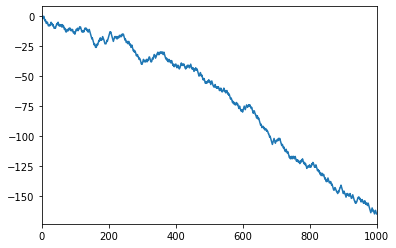

In [63]:
## Adding plot functionality to visualise capital as a function of time, where the time interval is iteration number/hand

series = pd.Series(capital_stock)
series.plot()
pyplot.show()

Made a modification to replenish_shoe function, got rid of some arguments/parameters being passed into it, and declared them to be global variables.

Very peculiar behaviour is being observed at the moment. Percentage increase in player capital stock after 20 iterations was observed to be around 133%...obviously is completely wrong.

Bug that needs to be investigated - first thought it was to do with either the lack of termination during Blackjack, or because of the lack of distinction between hard and soft hands.

Looked at flow diagram and realised that the getcards() and shuffler() were also included within the simulator loop - they should be outside the loop, and they are both called by the replenish_shoe() module, which is in the loop.

Now that has been corrected, percentage change in player capital stock after 20 iterations is -20%

Need to check the integrity of the simulator. In particular given that new unfamiliar features have been added - in particular check the global variable definition, and how variables are passed from function to function within the simulator.

Another pathological behaviour observed is where the simulator gets stuck - capital stock is populated with one item with no change after 10 rounds. Every round is a draw with dealer and playeer getting 21. 

Investigate the payout module, investigate what happens to taking from shoe when hands are a draw. 

Amended payout module to include addition to capital stock list with new unchanged post-draw capital stock.

Further pathological behaviour in simulator - capital keeps increasing by one.

Lots of issues now. Might need to revisit the drawing board. 

Module for one shoe works, and can replenish the shoe indefinitely, by pressing execute. No biggie. 

Scope of the issue:

Once the simulator version is used issues are encountered - Set a random seed to fix the card shuffle. 10 iterations of the simulator should yield exactly the same results as repeatedly running the individual shoe module.

Running the simulator straight away after a variable reset yields an error.
Every time.

Error message: player is not defined in "for card in player" inside "playerturn()" inside "for iteration in range(iterations)" loop inside "blackjack_simulator(iteration)" function.

Observation in simulator case: player is being used as an iterator inside the playerturn() function, and is referring to an object outside that function.

Observation in individual case: exactly same, except, not within in a for loop, nor within a function. 

Two things to try - as no amendments to player are being made, its only being passed as an iterator, try passing it as an argument in to playerturn() first, and then try as a global variable. And also try a simple test case

Anticipation is that this will also happen for the dealerturn() function. Correct

Anticipate also for handoutcome() as it refers to playerscore and dealerscore variables. Correct
Anticipate for payoutloss() as it refers to capital_stock variable. Simulator ran without this throwing an error. 

Let's make this refer to capital_stock outside the function, loop and simulator function by declaring it as a global.

Used random seed and still cannot replicate results with both simulator and repeated iterations of the individual module.

Instead of starting from what's not working and fix it; why not start from what is working - the individual module, and layer by layer build up to the simulator. So get it working with a for loop first, then place it inside a function.

1. Passing appropriate arguments which in function definitions 

Ok. We now have a working simulator module that can iterate many times, but I have a feeling it is quite inefficient. I want to continue building the rest of the modules before optimising it for algorithmic efficiency.

As I am looping and calling a sequence of functions, could think about iterating over them - programming extension.

In [132]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
for i in capital_stock:
    